In [124]:
import os
import warnings

warnings.filterwarnings("ignore")

In [125]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MQF2DistributionLoss, QuantileLoss, MAPE

In [126]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.models import NBeats
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting import TemporalFusionTransformer, Baseline, TimeSeriesDataSet

# Generate example


In [127]:
data = pd.read_csv('2010_present.csv') # change file path
data["time_idx"] = data.index
data["series"] = 0
data

,timestamp,total_amount,time_idx,series
0,2010-01-01,148173.71,0,0
1,2010-01-02,165787.50,1,0
2,2010-01-03,162360.15,2,0
3,2010-01-04,164382.94,3,0
4,2010-01-05,171372.72,4,0
...,...,...,...,...
3706,2020-02-24,239531.25,3706,0
3707,2020-02-25,260166.72,3707,0
3708,2020-02-26,244752.97,3708,0
3709,2020-02-27,224899.99,3709,0


In [128]:
max_encoder_length = 2300
max_prediction_length = 700

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="total_amount",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["total_amount"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [129]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=0.1)
net = NHiTS.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    loss=MAPE(),
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
)



INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.004786300923226385
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.004786300923226385
INFO: Restoring states from the checkpoint path at /content/.lr_find_1bc9f5cd-2674-4f10-8ceb-9ad7f41dacf8.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_1bc9f5cd-2674-4f10-8ceb-9ad7f41dacf8.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_1bc9f5cd-2674-4f10-8ceb-9ad7f41dacf8.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_1bc9f5cd-2674-4f10-8ceb-9ad7f41dacf8.ckpt


suggested learning rate: 0.004786300923226385


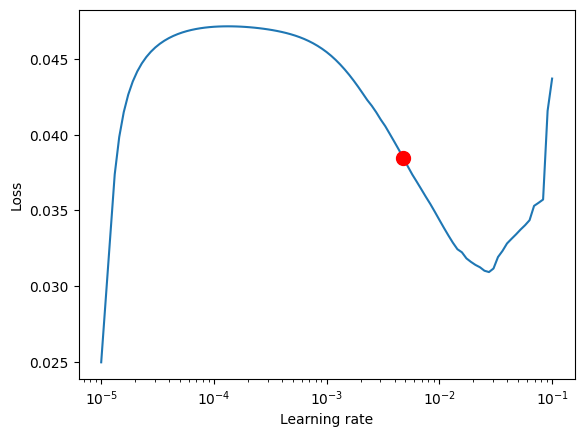

In [130]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e-1
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [131]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=5,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=True,
)


net = NHiTS.from_dataset(
    training,
    learning_rate=5e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
    loss=MAPE(),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | MAPE           | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 664 K  | train
-----------------------------------------------------------
664 K     Trainable params
0         Non-trainable params
664 K     Total params
2.658     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name            | Type           | Params | Mode 
--

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [132]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)

In [133]:
raw_predictions = best_model.predict(val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [134]:
raw_predictions

Prediction(output=Output(prediction=tensor([[[201288.5938],
         [205488.2656],
         [206288.4375],
         [202697.7656],
         [204570.9531],
         [203513.2656],
         [203089.9688],
         [204254.4844],
         [205800.2031],
         [203183.4062],
         [202457.3594],
         [203288.9375],
         [203831.8438],
         [204595.2188],
         [205218.2812],
         [204164.7344],
         [204830.4062],
         [204368.6406],
         [203667.6094],
         [204645.3281],
         [206459.2500],
         [204616.7188],
         [206394.7344],
         [201536.1250],
         [203323.5781],
         [205589.7188],
         [204780.4219],
         [203729.2656],
         [203009.5312],
         [203548.9531],
         [203856.9219],
         [206255.2500],
         [204526.0469],
         [203151.0938],
         [203307.1562],
         [202975.5469],
         [205601.4219],
         [203417.5938],
         [203278.2812],
         [201785.3438],
    

In [140]:
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
sns.set_theme(style= 'darkgrid' )

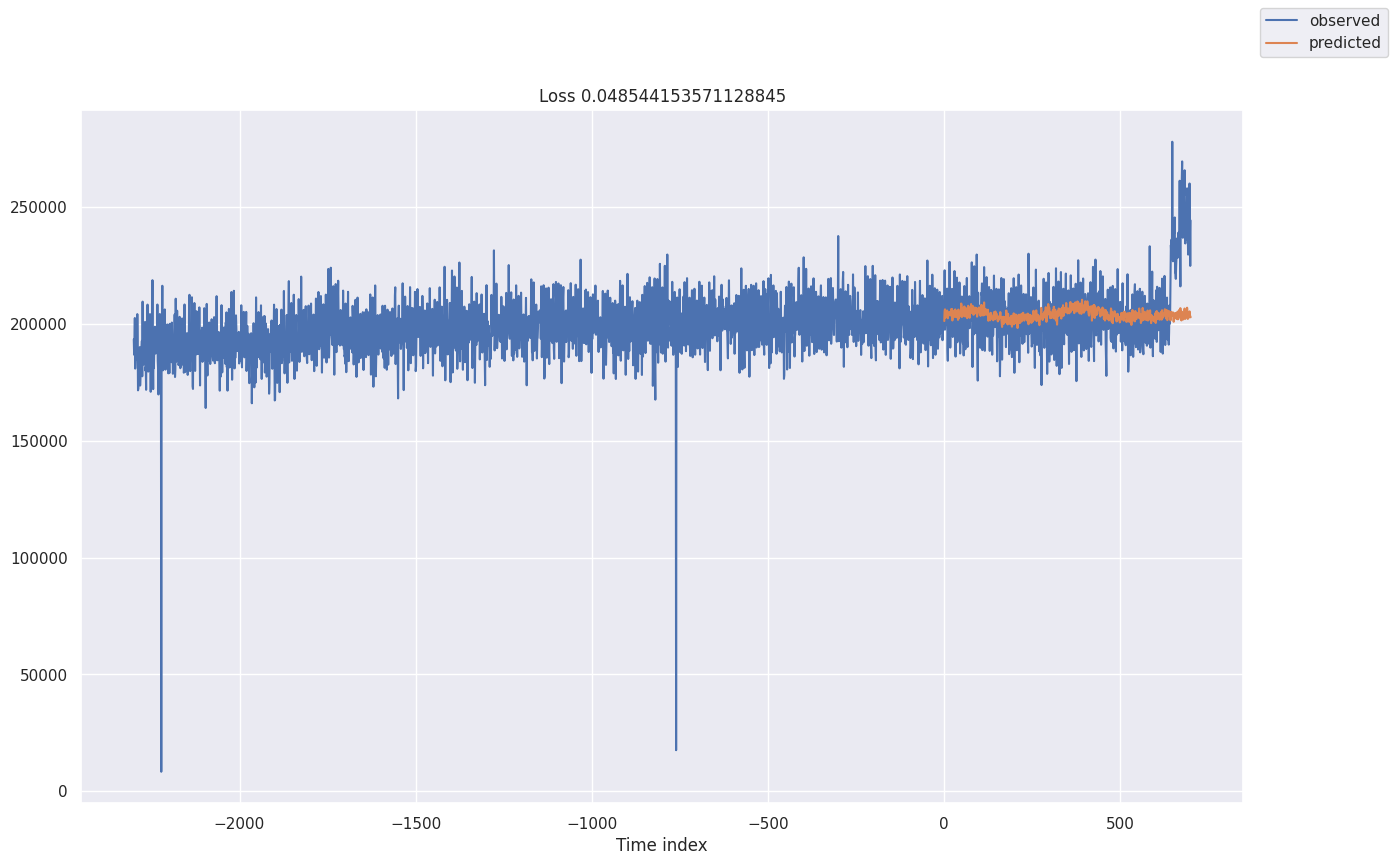

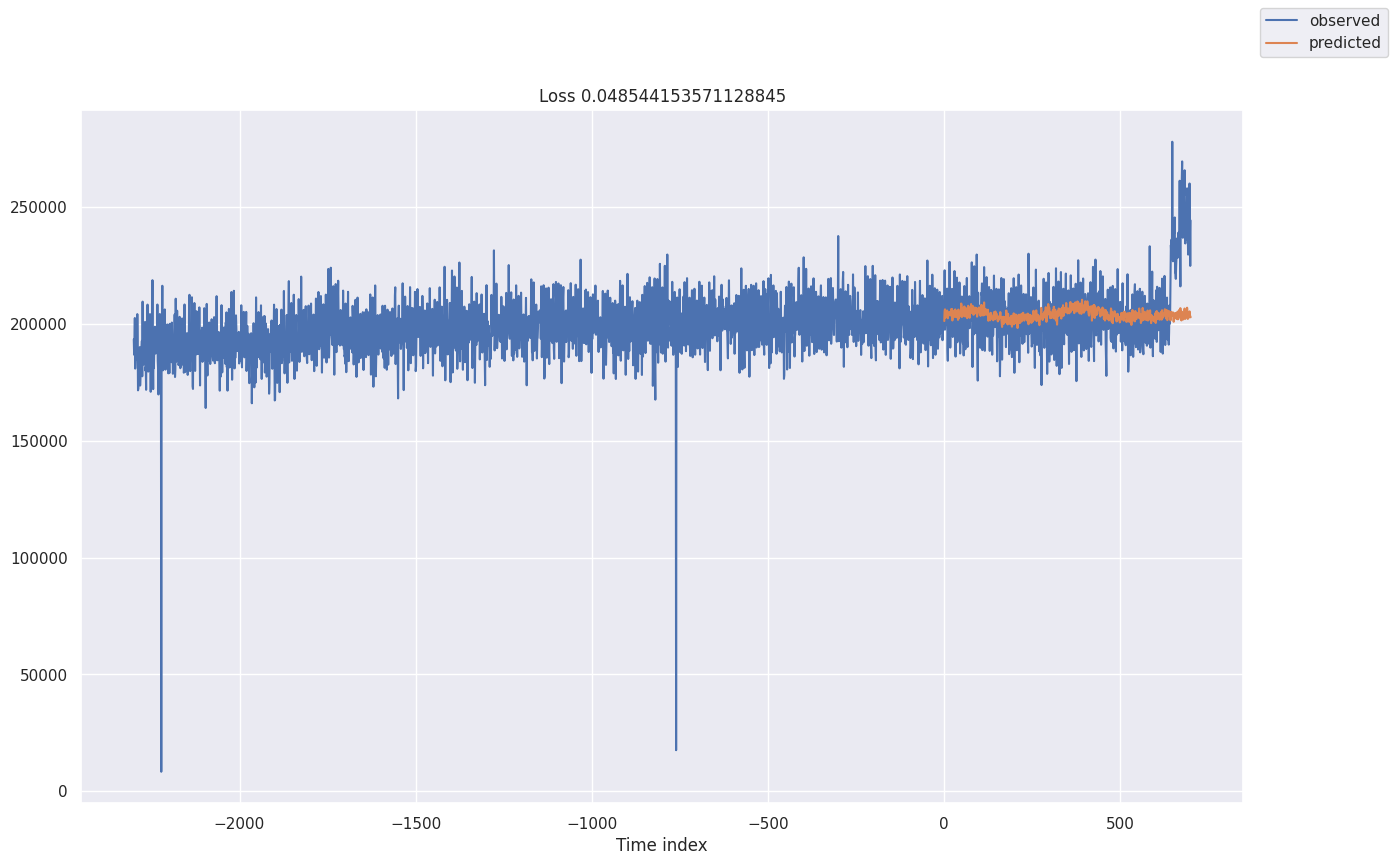

In [154]:

fig, ax = plt.subplots(figsize=(15, 9))
best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True, ax=ax)

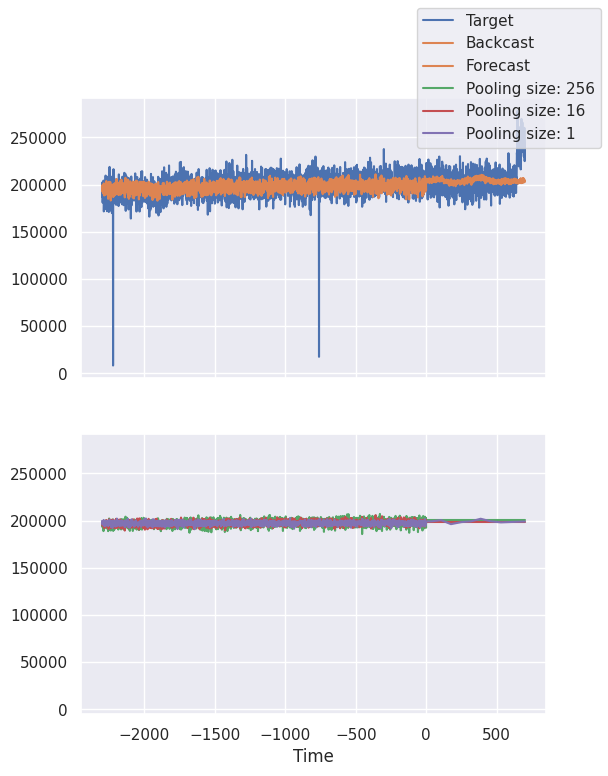

In [166]:

fig = best_model.plot_interpretation(raw_predictions.x, raw_predictions.output, idx=0)

In [170]:
fig.set_size_inches(15, 9)


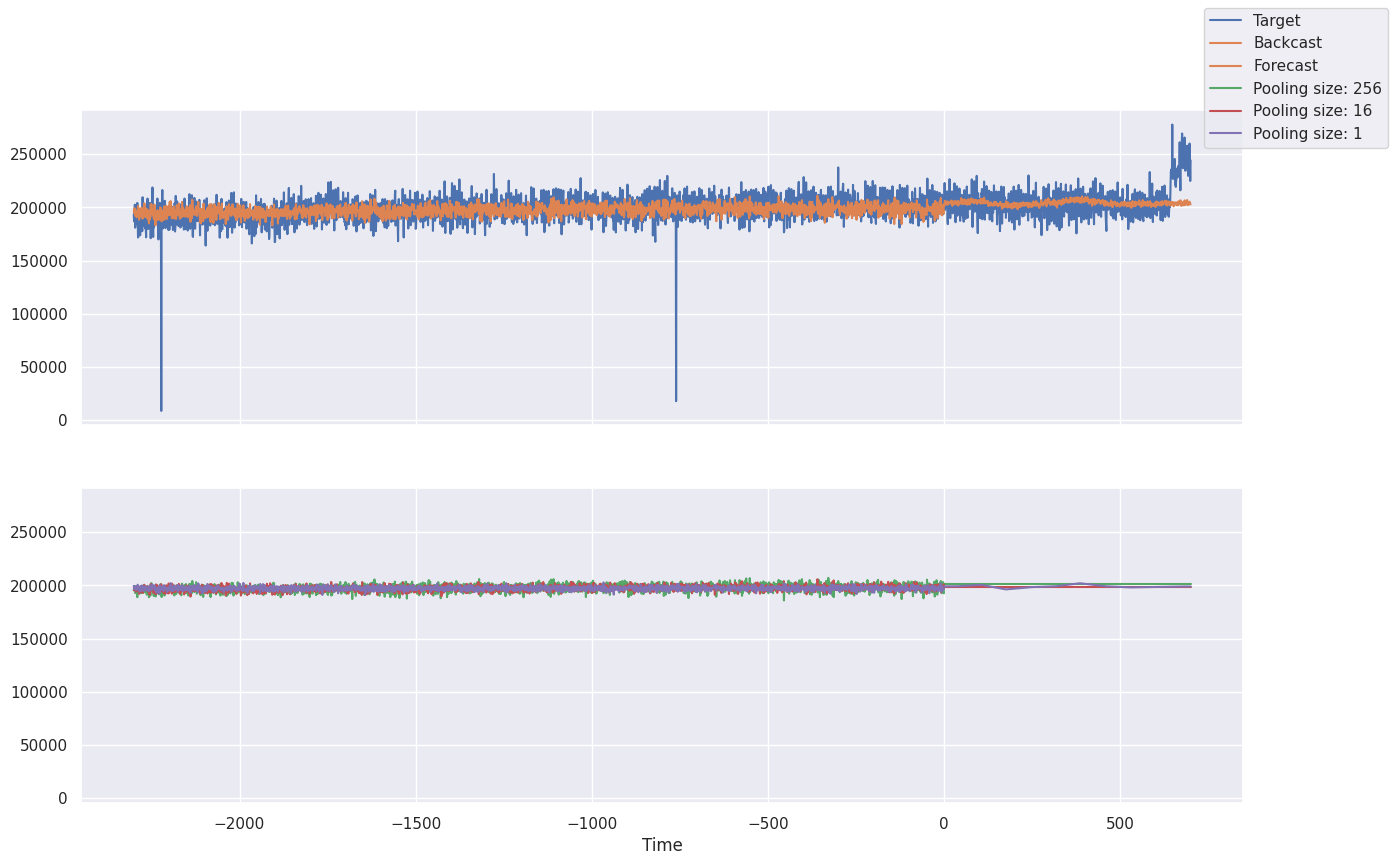

In [171]:
fig